# 引入必要库

In [33]:
# 引入必要库
import pandas as pd
import numpy as np
import torch
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
from matplotlib import pyplot as plt
from model.vae_pipeline import train_vae
from model.anomaly_detection_pipeline import train_vae_anomaly_detection

# 选择设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 数据准备

In [34]:
df_application_record = pd.read_csv("dataset/application_record.csv")
df_credit_record = pd.read_csv("dataset/credit_record.csv")

In [35]:
# 丢弃重复ID数据
df_application_record = df_application_record.drop_duplicates(subset = 'ID', keep = False)

In [36]:
# 调整数据框，以便仅使用一致的ID进行处理
df_application_record = df_application_record[df_application_record['ID'].isin(df_credit_record['ID'])]
df_credit_record = df_credit_record[df_credit_record['ID'].isin(df_application_record['ID'])]

# 数据清洗

In [37]:
# 生成标签用于柱状图
label_dict = {'1': 0, '2': 0, '3': 0, '4': 0, '5': 0, 'X': -1, 'C': 1, '0': 1}
df_credit_record['APPROVED'] = df_credit_record['STATUS'].map(label_dict)
df_credit_record = df_credit_record[df_credit_record['APPROVED'] != -1]

In [38]:
# 合并数据
df_application_record = df_application_record.merge(df_credit_record, on='ID')

In [39]:
df_application_record = df_application_record[df_application_record['MONTHS_BALANCE']==-4]
df_application_record.loc[df_application_record["NAME_INCOME_TYPE"]=="Pensioner","OCCUPATION_TYPE"] = "Pension"
df_application_record.loc[df_application_record["NAME_INCOME_TYPE"]=="Commercial associate","OCCUPATION_TYPE"] = "Commercial associate"
df_application_record.loc[df_application_record["NAME_INCOME_TYPE"]=="State servant","OCCUPATION_TYPE"] = "State servant"
df_application_record.loc[df_application_record["NAME_INCOME_TYPE"]=="Student","OCCUPATION_TYPE"] = "Student"
df_application_record = df_application_record.dropna()

In [40]:
df_application_record['Work_Time'] = -(df_application_record['DAYS_EMPLOYED'])//365

df_application_record = df_application_record.drop(df_application_record[df_application_record['Work_Time']>50].index)
df_application_record = df_application_record.drop(df_application_record[df_application_record['Work_Time']<0].index)
df_application_record = df_application_record.drop(columns=['STATUS'])
df_application_record.drop(['DAYS_EMPLOYED'],axis=1,inplace=True)


In [41]:
baseline_date = pd.to_datetime('2023-01-01')
df_application_record['BIRTH_DATE'] = baseline_date + pd.to_timedelta(df_application_record['DAYS_BIRTH'], unit='D')
df_application_record['AGE'] = (baseline_date - df_application_record['BIRTH_DATE']).dt.days // 365
df_application_record = df_application_record.drop(columns=['DAYS_BIRTH','BIRTH_DATE'])

In [42]:
onehot = False
if onehot:
    categorical_columns = ['CODE_GENDER', 'NAME_FAMILY_STATUS', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
    dummy_columns = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
else:
    categorical_columns = ['CODE_GENDER', 'NAME_FAMILY_STATUS', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
    dummy_columns = []
categorical_df = df_application_record[categorical_columns]
categorical_df = categorical_df.apply(lambda x: pd.factorize(x)[0])
categorical_df = pd.DataFrame(categorical_df)
df_application_record[categorical_columns] = categorical_df
df_application_record = pd.get_dummies(df_application_record, columns=dummy_columns)
df_application_record.to_csv('dataset.csv', index=False)

# 创建数据集

In [43]:
# scaler = MinMaxScaler()
# df_application_record['AMT_INCOME_TOTAL']=scaler.fit_transform(df_application_record['AMT_INCOME_TOTAL'].values.reshape(-1, 1))
# df_application_record['DAYS_EMPLOYED']=scaler.fit_transform(df_application_record['DAYS_EMPLOYED'].values.reshape(-1, 1))
# df_application_record['MONTHS_BALANCE']=scaler.fit_transform(df_application_record['MONTHS_BALANCE'].values.reshape(-1, 1))
# scaler = StandardScaler()
# df_application_record['CNT_FAM_MEMBERS']=scaler.fit_transform(df_application_record['CNT_FAM_MEMBERS'].values.reshape(-1, 1))
# df_application_record['AGE']=scaler.fit_transform(df_application_record['AGE'].values.reshape(-1, 1))

negative_data_orgin = df_application_record[df_application_record['APPROVED']==0]
negative_data = negative_data_orgin.drop(['APPROVED', 'ID','CODE_GENDER'], axis = 1)

X = df_application_record.drop(['APPROVED', 'ID','CODE_GENDER'], axis = 1)
y = df_application_record['APPROVED']
X = np.array(X,dtype=float)
y = np.array(y, dtype=int)

X_train, X_test, y_train, y_test = train_test_split(X, y)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)

negative_data = scalar.fit_transform(np.array(negative_data,dtype=float))
negative_label_list = np.zeros(len(negative_data))


# 创建 RandomUnderSampler 对象
undersampler = RandomUnderSampler(sampling_strategy='majority')

# 使用 RandomUnderSampler 来生成平衡的训练集
X_train_under_random, y_train_under_random = undersampler.fit_resample(X_train, y_train)

# 创建RandomOverSampler对象
oversampler = RandomOverSampler(sampling_strategy='minority')

# 使用RandomOverSampler来生成平衡的训练集
X_train_over_random, y_train_over_random = oversampler.fit_resample(X_train, y_train)

# 创建TomekLinks对象
undersampler = TomekLinks()

# 使用TomekLinks来生成平衡的训练集
X_train_under_tomelinks, y_train_under_tomelinks = undersampler.fit_resample(X_train, y_train)

# 创建SMOTE对象
smote = SMOTE(sampling_strategy='minority',random_state=42)

# 使用SMOTE来生成平衡的训练集
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [44]:
data_dict = {
    'Original Data': (X_train, y_train),
    'Over-sampled Data': (X_train_over_random, y_train_over_random),
    'Under-sampled Data': (X_train_under_random, y_train_under_random),
    'Tomelinks Data': (X_train_under_tomelinks, y_train_under_tomelinks),
    'SMOTE Data': (X_train_smote, y_train_smote)
}

# 分类

In [45]:
performance_data= []

## LightGBM

In [46]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.05,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5,
    'n_estimators': 100,
    'colsample_bytree': .5,
    'min_child_samples': 100,
    'subsample': .9,
    'importance_type': 'gain',
    'random_state': 71,
    'num_leaves': 32,
    'force_col_wise': True,
    'scale_pos_weight': 1,
    'bagging_freq': 5,
}


In [47]:
for method_name, (X_train_processed, y_train_processed) in data_dict.items():
    lgb_model = lgb.LGBMClassifier(**params, verbose=-1)

    lgb_model.fit(X_train_processed, y_train_processed)

    print(len(negative_data))
    y_pred = lgb_model.predict(X_test)
    y_prob = lgb_model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    negative_data_pred = lgb_model.predict(negative_data)
    negative_accuracy = accuracy_score(negative_label_list, negative_data_pred)

    print(
        classification_report(negative_label_list,
                              negative_data_pred,
                              zero_division=0))

    performance_data.append({
        'Classification Method': 'LightGBM',
        'Data Process Method': method_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Negative Accuracy': negative_accuracy,
    })

300
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.98      1.00      0.99      3665

    accuracy                           0.98      3749
   macro avg       0.49      0.50      0.49      3749
weighted avg       0.96      0.98      0.97      3749

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     300.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00     300.0
   macro avg       0.00      0.00      0.00     300.0
weighted avg       0.00      0.00      0.00     300.0

300
              precision    recall  f1-score   support

           0       0.04      0.36      0.08        84
           1       0.98      0.82      0.90      3665

    accuracy                           0.81      3749
   macro avg       0.51      0.59      0.49      3749
weighted avg       0.96      0.81      0.88      3749

           

d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


300
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.98      1.00      0.99      3665

    accuracy                           0.98      3749
   macro avg       0.49      0.50      0.49      3749
weighted avg       0.96      0.98      0.97      3749

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     300.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00     300.0
   macro avg       0.00      0.00      0.00     300.0
weighted avg       0.00      0.00      0.00     300.0

300
              precision    recall  f1-score   support

           0       0.02      0.99      0.04        84
           1       0.98      0.02      0.03      3665

    accuracy                           0.04      3749
   macro avg       0.50      0.50      0.04      3749
weighted avg       0.96      0.04      0.03      3749

           

d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## RandomForest

In [48]:
for method_name, (X_train_processed, y_train_processed) in data_dict.items():
    rfc = RandomForestClassifier(n_estimators=1000, max_features=12)
    rfc.fit(X_train_processed, y_train_processed)
    predictions = rfc.predict(X_test)
    print(f"Classification Report for {method_name} on Test Data:")
    print(classification_report(y_test, predictions))
    negative_predictions = rfc.predict(negative_data)
    print(f"Classification Report for {method_name} on Negative Data:")
    print(
        classification_report(negative_label_list,
                              negative_predictions,
                              zero_division=0))
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    performance_data.append({
        'Classification Method': 'Random Forest',
        'Data Process Method': method_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Negative Accuracy': negative_accuracy,
    })

Classification Report for Original Data on Test Data:
              precision    recall  f1-score   support

           0       0.17      0.04      0.06        84
           1       0.98      1.00      0.99      3665

    accuracy                           0.97      3749
   macro avg       0.57      0.52      0.52      3749
weighted avg       0.96      0.97      0.97      3749

Classification Report for Original Data on Negative Data:
              precision    recall  f1-score   support

         0.0       1.00      0.02      0.03       300
         1.0       0.00      0.00      0.00         0

    accuracy                           0.02       300
   macro avg       0.50      0.01      0.02       300
weighted avg       1.00      0.02      0.03       300

Classification Report for Over-sampled Data on Test Data:
              precision    recall  f1-score   support

           0       0.12      0.20      0.15        84
           1       0.98      0.96      0.97      3665

    accuracy

## AdaBoost for Decision Tree

In [49]:
for method_name, (X_train_processed, y_train_processed) in data_dict.items():
    # 使用决策树桩作为弱分类器，也可以选择其他弱分类器
    base_classifier = DecisionTreeClassifier(max_depth=1)

    # 使用AdaBoost分类器
    adaboost = AdaBoostClassifier(base_classifier,
                                  n_estimators=1000,
                                  algorithm='SAMME',
                                  random_state=42)

    # 训练模型
    adaboost.fit(X_train_processed, y_train_processed)

    # 在测试集上进行预测和评估
    predictions_test = adaboost.predict(X_test)
    print(f"Classification Report for {method_name} on Test Data:")
    print(classification_report(y_test, predictions_test))

    # 在负样本数据上进行预测和评估
    predictions_negative = adaboost.predict(negative_data)
    print(f"Classification Report for {method_name} on Negative Data:")
    print(
        classification_report(negative_label_list,
                              predictions_negative,
                              zero_division=0))
    accuracy = accuracy_score(y_test, predictions_test)
    precision = precision_score(y_test, predictions_test)
    recall = recall_score(y_test, predictions_test)
    f1 = f1_score(y_test, predictions_test)
    performance_data.append({
        'Classification Method': 'AdaBoost for Decision Tree',
        'Data Process Method': method_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Negative Accuracy': negative_accuracy,
    })

Classification Report for Original Data on Test Data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.98      1.00      0.99      3665

    accuracy                           0.98      3749
   macro avg       0.49      0.50      0.49      3749
weighted avg       0.96      0.98      0.97      3749

Classification Report for Original Data on Negative Data:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     300.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00     300.0
   macro avg       0.00      0.00      0.00     300.0
weighted avg       0.00      0.00      0.00     300.0



d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for Over-sampled Data on Test Data:
              precision    recall  f1-score   support

           0       0.02      0.38      0.04        84
           1       0.98      0.64      0.77      3665

    accuracy                           0.63      3749
   macro avg       0.50      0.51      0.41      3749
weighted avg       0.96      0.63      0.76      3749

Classification Report for Over-sampled Data on Negative Data:
              precision    recall  f1-score   support

         0.0       1.00      0.43      0.60       300
         1.0       0.00      0.00      0.00         0

    accuracy                           0.43       300
   macro avg       0.50      0.22      0.30       300
weighted avg       1.00      0.43      0.60       300

Classification Report for Under-sampled Data on Test Data:
              precision    recall  f1-score   support

           0       0.03      0.51      0.05        84
           1       0.98      0.58      0.73      3665

   

d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for SMOTE Data on Test Data:
              precision    recall  f1-score   support

           0       0.02      1.00      0.04        84
           1       0.00      0.00      0.00      3665

    accuracy                           0.02      3749
   macro avg       0.01      0.50      0.02      3749
weighted avg       0.00      0.02      0.00      3749

Classification Report for SMOTE Data on Negative Data:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       300

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metr

## SVM

In [50]:
for method_name, (X_train_processed, y_train_processed) in data_dict.items():
   # 使用 SVM 替代 RandomForestClassifier
   svm_model = SVC()
   svm_model.fit(X_train_processed, y_train_processed)

   # SVM 在测试集上的分类报告
   predictions_svm_test = svm_model.predict(X_test)
   print(f"Method: {method_name} - SVM Classification Report on Test Data:")
   print(classification_report(y_test, predictions_svm_test))

   # SVM 在负样本上的分类报告
   predictions_svm_negative = svm_model.predict(negative_data)
   print(
      f"Method: {method_name} - SVM Classification Report on Negative Data:")
   print(
      classification_report(negative_label_list,
                           predictions_negative,
                           zero_division=0))
   accuracy = accuracy_score(y_test, predictions_svm_test)
   precision = precision_score(y_test, predictions_svm_test)
   recall = recall_score(y_test, predictions_svm_test)
   f1 = f1_score(y_test, predictions_svm_test)
   performance_data.append({
       'Classification Method': 'SVM',
       'Data Process Method': method_name,
       'Accuracy': accuracy,
       'Precision': precision,
       'Recall': recall,
       'F1 Score': f1,
       'Negative Accuracy': negative_accuracy,
   })


Method: Original Data - SVM Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.98      1.00      0.99      3665

    accuracy                           0.98      3749
   macro avg       0.49      0.50      0.49      3749
weighted avg       0.96      0.98      0.97      3749

Method: Original Data - SVM Classification Report on Negative Data:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       300

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Method: Over-sampled Data - SVM Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.03      0.27      0.06        84
           1       0.98      0.82      0.89      3665

    accuracy                           0.80      3749
   macro avg       0.51      0.55      0.47      3749
weighted avg       0.96      0.80      0.87      3749

Method: Over-sampled Data - SVM Classification Report on Negative Data:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       300

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

Method: Under-sampled Data - SVM Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.02      0.42      0.05        84
           1       0.98      0.62      0.76      3665

    accuracy               

d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Method: SMOTE Data - SVM Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.04      0.23      0.06        84
           1       0.98      0.86      0.92      3665

    accuracy                           0.85      3749
   macro avg       0.51      0.54      0.49      3749
weighted avg       0.96      0.85      0.90      3749

Method: SMOTE Data - SVM Classification Report on Negative Data:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       300

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



## AdaBoost for SVM

In [51]:
# for method_name, (X_train_processed, y_train_processed) in data_dict.items():
#     # 使用支持向量机作为弱分类器
#     base_classifier = SVC(kernel='linear', C=1.0)

#     # 使用AdaBoost分类器
#     adaboost = AdaBoostClassifier(base_classifier,
#                                   n_estimators=1000,
#                                   algorithm='SAMME',
#                                   random_state=42)

#     # 训练模型
#     adaboost.fit(X_train_processed, y_train_processed)

#     # 在测试集上进行预测和评估
#     predictions_test = adaboost.predict(X_test)
#     print(f"Classification Report for {method_name} on Test Data:")
#     print(classification_report(y_test, predictions_test))

#     # 在负样本数据上进行预测和评估
#     predictions_negative = adaboost.predict(negative_data)
#     print(f"Classification Report for {method_name} on Negative Data:")
#     print(
#         classification_report(negative_label_list,
#                               predictions_negative,
#                               zero_division=0))
#     accuracy = accuracy_score(y_test, predictions_test)
#     precision = precision_score(y_test, predictions_test)
#     recall = recall_score(y_test, predictions_test)
#     f1 = f1_score(y_test, predictions_test)
#     performance_data.append({
#         'Classification Method': 'AdaBoost for SVM',
#         'Data Process Method': method_name,
#         'Accuracy': accuracy,
#         'Precision': precision,
#         'Recall': recall,
#         'F1 Score': f1,
#         'Negative Accuracy': negative_accuracy,
#     })

# 特征提取

In [52]:
model_dict = {}

for method_name, (X_train_processed, _) in data_dict.items():
    print("Training for the method: " + method_name)
    model = train_vae(X_train=X_train_processed, X_test=X_test, progress=True, num_epoch=250).eval()
    model_dict[method_name] = model

total_dict = {}

for method_name, (X_train_processed, _) in data_dict.items():
    model = model_dict[method_name]
    total_dict[method_name] = (X_train_processed, _, model)

Training for the method: Original Data


Epoch 2/250:   0%|          | 0/3 [00:00<?, ?it/s]

Best epoch: 249
Training for the method: Over-sampled Data


Best epoch: 249
Training for the method: Under-sampled Data


Best epoch: 249
Training for the method: Tomelinks Data


Best epoch: 249
Training for the method: SMOTE Data


Best epoch: 249


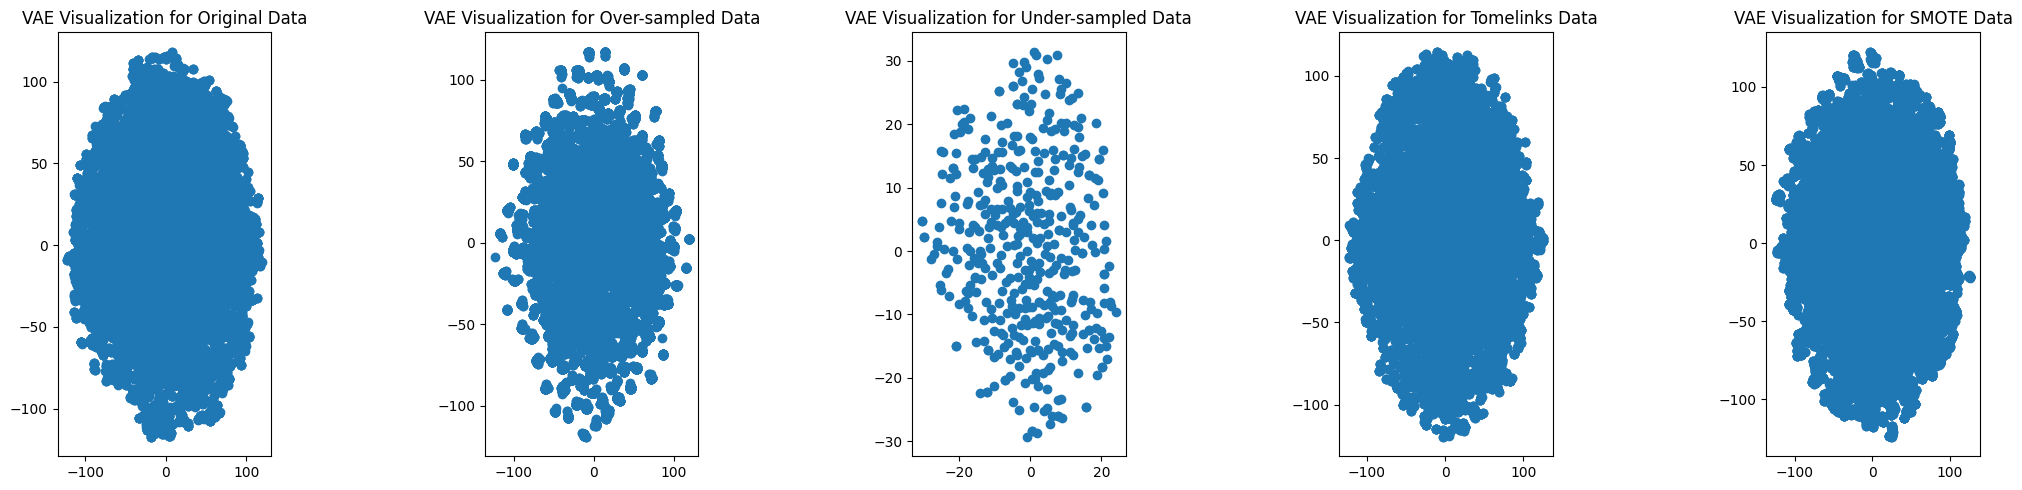

In [53]:
# 计算有多少个方法
num_methods = len(total_dict)

# 创建一个包含多个子图的Figure
fig, axes = plt.subplots(nrows=1, ncols=num_methods, figsize=(20, 5))

# 遍历每个方法并在相应的子图中绘制散点图
for i, (method_name, (X_train_processed, _, model)) in enumerate(total_dict.items()):
    model.eval()
    with torch.no_grad():
        encoded_data = model.encoder(torch.Tensor(X_train_processed).to(device))
        encoded_data = encoded_data.cpu().numpy()
        tsne = TSNE(n_components=2)
        reduced_data = tsne.fit_transform(encoded_data)

    # 绘制每个方法的散点图
    axes[i].scatter(reduced_data[:, 0], reduced_data[:, 1])
    axes[i].set_title(f"VAE Visualization for {method_name}")

# 调整布局，以防止子图重叠
plt.tight_layout()
plt.subplots_adjust(wspace=1.0)  # 调整水平间距
plt.show()

## LightGBM for VAE data

In [54]:
for method_name, (X_train_processed, y_train_processed, model) in total_dict.items():
    lgb_model = lgb.LGBMClassifier(**params, verbose=-1)

    lgb_model.fit(model.encoder(torch.Tensor(X_train_processed).to(device)).cpu().detach().numpy(), y_train_processed)

    y_pred = lgb_model.predict(model.encoder(torch.Tensor(X_test).to(device)).detach().cpu().numpy())

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(classification_report(y_test, y_pred))
    negative_data_pred = lgb_model.predict(model.encoder(torch.Tensor(negative_data).to(device)).detach().cpu().numpy())
    negative_accuracy = accuracy_score(negative_label_list, negative_data_pred)

    print(
        classification_report(negative_label_list,
                              negative_data_pred,
                              zero_division=0))

    performance_data.append({
        'Classification Method': 'LightGBM for VAE data',
        'Data Process Method': method_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Negative Accuracy': negative_accuracy,
    })


d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.98      1.00      0.99      3665

    accuracy                           0.98      3749
   macro avg       0.49      0.50      0.49      3749
weighted avg       0.96      0.98      0.97      3749

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     300.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00     300.0
   macro avg       0.00      0.00      0.00     300.0
weighted avg       0.00      0.00      0.00     300.0

              precision    recall  f1-score   support

           0       0.04      0.40      0.07        84
           1       0.98      0.75      0.85      3665

    accuracy                           0.74      3749
   macro avg       0.51      0.58      0.46      3749
weighted avg       0.96      0.74      0.83      3749

              preci

d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVM for VAE data

In [55]:
for method_name, (X_train_processed, y_train_processed, model) in total_dict.items():
    svm_model = SVC()
    train_feature = model.encoder(torch.Tensor(X_train_processed).to(device)).cpu().detach().numpy()
    test_feature = model.encoder(torch.Tensor(X_test).to(device)).detach().cpu().numpy()
    svm_model.fit(train_feature, y_train_processed)
    predictions = svm_model.predict(test_feature)
    print(classification_report(y_test, predictions))
    negative_predictions = svm_model.predict(model.encoder(torch.Tensor(negative_data).to(device)).detach().cpu().numpy())
    print(
        classification_report(negative_label_list,
                              negative_predictions,
                              zero_division=0))
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    negative_accuracy = accuracy_score(negative_label_list, negative_predictions)
    performance_data.append({
        'Classification Method': 'SVM for VAE data',
        'Data Process Method': method_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Negative Accuracy': negative_accuracy,
    })

d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.98      1.00      0.99      3665

    accuracy                           0.98      3749
   macro avg       0.49      0.50      0.49      3749
weighted avg       0.96      0.98      0.97      3749

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     300.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00     300.0
   macro avg       0.00      0.00      0.00     300.0
weighted avg       0.00      0.00      0.00     300.0

              precision    recall  f1-score   support

           0       0.04      0.42      0.07        84
           1       0.98      0.76      0.86      3665

    accuracy                           0.75      3749
   macro avg       0.51      0.59      0.46      3749
weighted avg       0.96      0.75      0.84      3749

              preci

d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.98      1.00      0.99      3665

    accuracy                           0.98      3749
   macro avg       0.49      0.50      0.49      3749
weighted avg       0.96      0.98      0.97      3749

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     300.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00     300.0
   macro avg       0.00      0.00      0.00     300.0
weighted avg       0.00      0.00      0.00     300.0

              precision    recall  f1-score   support

           0       0.03      0.39      0.05        84
           1       0.98      0.68      0.81      3665

    accuracy                           0.68      3749
   macro avg       0.50      0.54      0.43      3749
weighted avg       0.96      0.68      0.79      3749

              preci

## AdaBoost for Decision Tree for VAE data

In [56]:
for method_name, (X_train_processed, y_train_processed, model) in total_dict.items():
    train_feature = model.encoder(torch.Tensor(X_train_processed).to(device)).cpu().detach().numpy()
    test_feature = model.encoder(torch.Tensor(X_test).to(device)).detach().cpu().numpy()

    # 使用决策树桩作为弱分类器，也可以选择其他弱分类器
    base_classifier = DecisionTreeClassifier(max_depth=1)

    # 使用AdaBoost分类器
    adaboost = AdaBoostClassifier(base_classifier,
                                  n_estimators=1000,
                                  algorithm='SAMME',
                                  random_state=42)

    # 训练模型
    adaboost.fit(train_feature, y_train_processed)

    # 在测试集上进行预测和评估
    predictions_test = adaboost.predict(test_feature)
    print(f"Classification Report for {method_name} on Test Data:")
    print(classification_report(y_test, predictions_test))

    # 在负样本数据上进行预测和评估
    predictions_negative = adaboost.predict(model.encoder(torch.Tensor(negative_data).to(device)).detach().cpu().numpy())
    print(f"Classification Report for {method_name} on Negative Data:")
    print(
        classification_report(negative_label_list,
                              predictions_negative,
                              zero_division=0))
    accuracy = accuracy_score(y_test, predictions_test)
    precision = precision_score(y_test, predictions_test)
    recall = recall_score(y_test, predictions_test)
    f1 = f1_score(y_test, predictions_test)
    negative_accuracy = accuracy_score(negative_label_list, predictions_negative)
    performance_data.append({
        'Classification Method': 'AdaBoost for Decision Tree with vae data',
        'Data Process Method': method_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Negative Accuracy': negative_accuracy,
    })

Classification Report for Original Data on Test Data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.98      1.00      0.99      3665

    accuracy                           0.98      3749
   macro avg       0.49      0.50      0.49      3749
weighted avg       0.96      0.98      0.97      3749

Classification Report for Original Data on Negative Data:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     300.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00     300.0
   macro avg       0.00      0.00      0.00     300.0
weighted avg       0.00      0.00      0.00     300.0

Classification Report for Over-sampled Data on Test Data:
              precision    recall  f1-score   support

           0       0.03      0.50      0.05        84
           1       0.98      0.61      0.75      3665

    accuracy

d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for SMOTE Data on Test Data:
              precision    recall  f1-score   support

           0       0.02      0.48      0.04        84
           1       0.98      0.55      0.70      3665

    accuracy                           0.55      3749
   macro avg       0.50      0.51      0.37      3749
weighted avg       0.96      0.55      0.69      3749

Classification Report for SMOTE Data on Negative Data:
              precision    recall  f1-score   support

         0.0       1.00      0.64      0.78       300
         1.0       0.00      0.00      0.00         0

    accuracy                           0.64       300
   macro avg       0.50      0.32      0.39       300
weighted avg       1.00      0.64      0.78       300



# Ensemble

In [57]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metrics': 'binary_logloss',
    'learning_rate': 0.05,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5,
    'n_estimators': 100,
    'colsample_bytree': .5,
    'min_child_samples': 100,
    'subsample': .9,
    'importance_type': 'gain',
    'random_state': 71,
    'num_leaves': 32,
    'force_col_wise': True,
    'scale_pos_weight': 1,
    'bagging_freq': 5,
}

## Stacking

In [58]:
# 使用决策树桩作为弱分类器，也可以选择其他弱分类器
base_classifier = DecisionTreeClassifier(max_depth=1)

# 使用AdaBoost分类器
adaboost = AdaBoostClassifier(base_classifier,
                              n_estimators=1000,
                              algorithm='SAMME',
                              random_state=42)

X_train_processed = total_dict['Under-sampled Data'][0]

# 训练模型
adaboost.fit(X_train_under_random, y_train_under_random)

# 在测试集上进行预测和评估
predictions_ada = adaboost.predict(X_test)
negative_accuracy_1 = adaboost.predict(negative_data)

In [59]:
# 使用LightGBM分类器
lgb_model = lgb.LGBMClassifier(**params, verbose=-1)

# 训练模型
lgb_model.fit(X_train_under_random, y_train_under_random)

# 在测试集上进行预测和评估
predictions_lgbm = lgb_model.predict(X_test)
negative_accuracy_2 = lgb_model.predict(negative_data)

In [60]:
# 创建元模型
meta_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 将基模型的预测结果作为特征
X_ensemble = np.column_stack((predictions_ada, predictions_lgbm))
negative_predictions = np.column_stack((negative_accuracy_1,negative_accuracy_2))

# 划分数据集
X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble = train_test_split(X_ensemble, y_test, test_size=0.2, random_state=42)

# 训练元模型
meta_model.fit(X_train_ensemble, y_train_ensemble)

# 预测
ensemble_predictions = meta_model.predict(X_test_ensemble)
negative_predictions = meta_model.predict(negative_predictions)

# 计算新的指标
accuracy_ensemble = accuracy_score(y_test_ensemble, ensemble_predictions)
negative_accuracy_ensemble = accuracy_score(negative_label_list, negative_predictions)
precision_ensemble = precision_score(y_test_ensemble, ensemble_predictions)
recall_ensemble = recall_score(y_test_ensemble, ensemble_predictions)
f1_ensemble = f1_score(y_test_ensemble, ensemble_predictions)

# 打印新的指标
print("Ensemble Model Metrics:")
print(f"Accuracy: {accuracy_ensemble:.4f}")
print(f"Precision: {precision_ensemble:.4f}")
print(f"Recall: {recall_ensemble:.4f}")
print(f"F1 Score: {f1_ensemble:.4f}")
print(f"Negative Accuracy: {negative_accuracy_ensemble:.4f}")

# 打印分类报告
print("Classification Report for Ensemble Model:")
print(classification_report(y_test_ensemble, ensemble_predictions))
performance_data.append({
    'Classification Method': 'Stacking Ensemble Model for AdaBoost and LightGBM',
    'Data Process Method': 'Under-sampled Data',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Negative Accuracy': negative_accuracy_ensemble,
})

Ensemble Model Metrics:
Accuracy: 0.9840
Precision: 0.9840
Recall: 1.0000
F1 Score: 0.9919
Negative Accuracy: 0.0000
Classification Report for Ensemble Model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.98      1.00      0.99       738

    accuracy                           0.98       750
   macro avg       0.49      0.50      0.50       750
weighted avg       0.97      0.98      0.98       750



d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Voting

In [61]:
# 创建投票分类器
voting_model = VotingClassifier(estimators=[('adaboost', adaboost), ('lgbm', lgb_model)], voting='hard')

# 训练投票模型
voting_model.fit(X_train_under_random, y_train_under_random)

# 预测
ensemble_predictions = voting_model.predict(X_test)
negative_predictions = voting_model.predict(negative_data)

# 计算新的指标
accuracy_ensemble = accuracy_score(y_test, ensemble_predictions)
negative_accuracy_ensemble = accuracy_score(negative_label_list, negative_predictions)
precision_ensemble = precision_score(y_test, ensemble_predictions)
recall_ensemble = recall_score(y_test, ensemble_predictions)
f1_ensemble = f1_score(y_test, ensemble_predictions)

# 打印新的指标
print("Ensemble Model Metrics:")
print(f"Accuracy: {accuracy_ensemble:.4f}")
print(f"Precision: {precision_ensemble:.4f}")
print(f"Recall: {recall_ensemble:.4f}")
print(f"F1 Score: {f1_ensemble:.4f}")
print(f"Negative Accuracy: {negative_accuracy_ensemble:.4f}")
performance_data.append({
    'Classification Method': 'Voting Ensemble Model for AdaBoost and LightGBM',
    'Data Process Method': 'Under-sampled Data',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Negative Accuracy': negative_accuracy_ensemble,
})

# 打印分类报告
print("Classification Report for Ensemble Model:")
print(classification_report(y_test, ensemble_predictions))


Ensemble Model Metrics:
Accuracy: 0.4583
Precision: 0.9795
Recall: 0.4554
F1 Score: 0.6217
Negative Accuracy: 0.6300
Classification Report for Ensemble Model:
              precision    recall  f1-score   support

           0       0.02      0.58      0.05        84
           1       0.98      0.46      0.62      3665

    accuracy                           0.46      3749
   macro avg       0.50      0.52      0.33      3749
weighted avg       0.96      0.46      0.61      3749



# Anomaly Detection

## VAE

In [62]:
Anomal_dict = {}
Anomal_model_list = []

for method_name, (X_train_processed, _) in data_dict.items():
    print("Training for the method: " + method_name)
    model = train_vae_anomaly_detection(X_train=X_train_processed, X_test=X_test, progress=True, num_epoch=250).eval()
    Anomal_model_list.append(model)
    Anomal_dict[method_name] = (X_train_processed, _, model)

Training for the method: Original Data


Epoch 1/250:   0%|          | 0/3 [00:00<?, ?it/s]

Best epoch: 249
Training for the method: Over-sampled Data


Best epoch: 249
Training for the method: Under-sampled Data


Best epoch: 249
Training for the method: Tomelinks Data


Best epoch: 249
Training for the method: SMOTE Data


Best epoch: 249


In [63]:
for method_name, (X_train_processed, _, model) in Anomal_dict.items():
    predictions = model.predict_anomaly(
        torch.Tensor(X_test).to(device),
        threshold=0.05).detach().cpu().numpy()
    negative_data_pred = model.predict_anomaly(
        torch.Tensor(negative_data).to(device),
        threshold=0.05).detach().cpu().numpy()

    # 计算评估指标
    report_test = classification_report(y_test, predictions, output_dict=True)
    report_negative = classification_report(negative_label_list, negative_data_pred, output_dict=True, zero_division=0)

    # 提取指标
    accuracy = accuracy_score(y_test, predictions)
    precision = report_test['1']['precision']
    recall = report_test['1']['recall']
    f1 = report_test['1']['f1-score']
    negative_accuracy = accuracy_score(negative_label_list, negative_data_pred)

    print(classification_report(y_test, predictions))
    print(
        classification_report(negative_label_list,
                              negative_data_pred,
                              zero_division=0))
    # 添加到 performance_data 列表中
    performance_data.append({
        'Classification Method': 'Anomaly Detection with VAE',
        'Data Process Method': method_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Negative Accuracy': negative_accuracy,
    })

d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.98      1.00      0.99      3665

    accuracy                           0.98      3749
   macro avg       0.49      0.50      0.49      3749
weighted avg       0.96      0.98      0.97      3749

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     300.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00     300.0
   macro avg       0.00      0.00      0.00     300.0
weighted avg       0.00      0.00      0.00     300.0

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.98      1.00      0.99      3665

    accuracy                           0.98      3749
   macro avg       0.49      0.50      0.49      3749
weighted avg       0.96      0.98      0.97      3749

              preci

d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Docu\DateMining\.venv\Lib\site-packages\sklearn\metr

In [64]:
data_df = pd.DataFrame(performance_data)
data_df = data_df.round({'Accuracy': 3, 'Precision': 3, 'Recall': 3, 'F1 Score': 3, 'Negative Accuracy': 3})

# 找到最佳性能数据的行
best_accuracy_row = data_df[data_df['Accuracy'] == data_df['Accuracy'].max()]
best_precision_row = data_df[data_df['Precision'] == data_df['Precision'].max()]
best_recall_row = data_df[data_df['Recall'] == data_df['Recall'].max()]
best_f1_score_row = data_df[data_df['F1 Score'] == data_df['F1 Score'].max()]
best_negative_accuracy_row = data_df[data_df['Negative Accuracy'] == data_df['Negative Accuracy'].max()]

# 输出最佳性能数据
print("best Accuracy Classification Method:", best_accuracy_row['Classification Method'].values[0])
print("Best Accuracy Data Process Method:", best_accuracy_row['Data Process Method'].values[0])
print("Best Accuracy Value:", best_accuracy_row['Accuracy'].values[0])

print("best Accuracy Classification Method:", best_precision_row['Classification Method'].values[0])
print("Best Precision Data Process Method:", best_precision_row['Data Process Method'].values[0])
print("Best Precision Value:", best_precision_row['Precision'].values[0])

print("best Accuracy Classification Method:", best_recall_row['Classification Method'].values[0])
print("Best Recall Data Process Method:", best_recall_row['Data Process Method'].values[0])
print("Best Recall Value:", best_recall_row['Recall'].values[0])

print("best Accuracy Classification Method:", best_f1_score_row['Classification Method'].values[0])
print("Best F1 Score Data Process Method:", best_f1_score_row['Data Process Method'].values[0])
print("Best F1 Score Value:", best_f1_score_row['F1 Score'].values[0])


print("best Accuracy Classification Method:", best_negative_accuracy_row['Classification Method'].values[0])
print("Best Negative Accuracy Data Process Method:", best_negative_accuracy_row['Data Process Method'].values[0])
print("Best Negative Accuracy Value:", best_negative_accuracy_row['Negative Accuracy'].values[0])
data_df.to_csv('output/performance_data.csv', index=False)

best Accuracy Classification Method: LightGBM
Best Accuracy Data Process Method: Original Data
Best Accuracy Value: 0.978
best Accuracy Classification Method: LightGBM
Best Precision Data Process Method: SMOTE Data
Best Precision Value: 0.984
best Accuracy Classification Method: LightGBM
Best Recall Data Process Method: Original Data
Best Recall Value: 1.0
best Accuracy Classification Method: LightGBM
Best F1 Score Data Process Method: Original Data
Best F1 Score Value: 0.989
best Accuracy Classification Method: LightGBM
Best Negative Accuracy Data Process Method: SMOTE Data
Best Negative Accuracy Value: 1.0
